<a href="https://colab.research.google.com/github/HeSH-0629/Keras-Study/blob/main/house_prise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021.01.10 D+125  

> 주택 가격 예측 (회귀, regression)

In [6]:
import keras
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

data들은 13종류의 지표들을 포함 (특성별로 수치가 다르기 때문에 정규화 작업 필요)  
target은 집값

In [7]:
mean = train_data.mean(axis=0) #특성들의 값을 따라 평균 계산
train_data-=mean
std=train_data.std(axis=0) #특성들의 값을 따라 표준편차 계산
train_data /= std # Z = (X-m)/std

test_data -= mean
test_data /= std

**모델구성**

In [8]:
from keras import models
from keras import layers

def build_model():
  model=models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) #특성들 (13가지)을 주입
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) #선형층을 남겨서 스칼라 회귀를 위해 값을 출력시킴
  model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
  return model

사용할 수 있는 자료의 개수가 적은 경우 **K-겹 검증**을 이용

In [10]:
import numpy as np

k=4
num_val_samples = len(train_data) // 4
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('처리중인 폴드 #', i)
  # 검증(validation) 데이터 준비: k번째 분할
  val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]

  # 훈련 데이터 만들기
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],
      axis=0)
  model = build_model()
  history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) #verbose=0 이면 훈련 과정 출력X
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)
average_mae_history = [
  np.mean([x[i]for x in all_mae_histories]) for i in range(num_epochs)] #폴드별로 평균 값을 계산하여 저장

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


**그래프 출력**

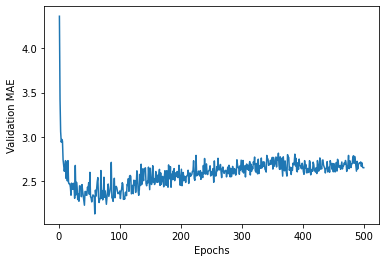

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프 범위가 크고 변동이 심하므로 **지수 평균 이동 (exponential moving average)** 사용

> 모든 지점에서 값을 **(이전 값* factor) + (현재 값 * (1- factor))** 로 변환  
> 앞의 50개 포인트가 튀므로 제외



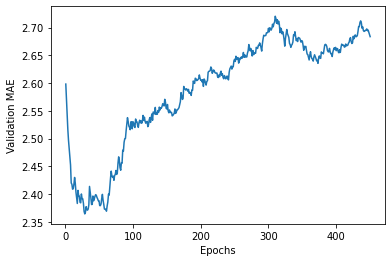

In [22]:
def smooth_curve(points, factor=0.9):
  smoothed_points= []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1- factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[50:])
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

마지막으로 새롭게 컴파일 한 모델을 얻고 전체 데이터로 훈련시킨 다음 테스트 진행

In [13]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 19.1576 - mae: 2.6946


현재 평균 적인 오차는 2694.6$